In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

In [2]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("./exercises").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from part4_superposition_and_saes.utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)
import part4_superposition_and_saes.tests as tests
import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

current PyTorch install was built with MPS enabled.
MPS is available


/Users/daniellee/Library/Caches/pypoetry/virtualenvs/toy-hierarchy-NsY2iPjH-py3.12/lib/python3.12/site-packages/accelerate/utils/imports.py:282: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


current PyTorch install was built with MPS enabled.
MPS is available


# TMH: Superposition in a Nonprivileged Basis

## Define Model

In [6]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features: int = 6
    tree_depth: int = 2
    branching_factor: int = 2
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0

class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)

        self.device = device


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        pass # See below for solutions


    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `model.importance` will always have shape (n_instances, n_features).
        '''
        pass # See below for solutions


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


tests.test_model(Model)

All tests in `test_model` passed!


In [7]:
def generate_batch(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of data. We'll return to this function later when we apply correlations.
    '''

    n_features = self.cfg.branching_factor ** (self.cfg.tree_depth + 1) - 1

    feat = t.zeros((batch_size, self.cfg.n_instances, n_features))

    rand_shape = (batch_size, self.cfg.n_instances)

    for level in range(self.cfg.tree_depth+1):
        if level == 0:
            feat[:, :, 0] = (t.ones(rand_shape))
            continue

        start_idx = 2**(level) - 1

        for i in range(2**(level-1)):
            feat[:, :, start_idx + 2*i] = (t.rand(rand_shape) > 0.5).to(t.int)
            feat[:, :, start_idx + 2*i + 1] = 1 - feat[:, :, start_idx + 2*i]

            # we need to zero out inactive features

            parent_idx = (start_idx + 2*i - 1) // 2

            feat[:, :, start_idx + 2*i] *= feat[:, :, parent_idx]
            feat[:, :, start_idx + 2*i + 1] *= feat[:, :, parent_idx]

    # shave off root
    feat = feat[:, :, 1:]

    feat = feat.to(self.device)

    return feat

In [8]:
Model.generate_batch = generate_batch

# tests.test_generate_batch(Model)

In [19]:
def calculate_loss(
    self: Model,
    out: Float[Tensor, "batch instances features"],
    batch: Float[Tensor, "batch instances features"],
) -> Float[Tensor, ""]:
    '''
    Calculates the loss for a given batch, using this loss described in the Toy Models paper:

        https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

    Remember, `self.importance` will always have shape (n_instances, n_features).
    '''
    error = self.importance * ((batch - out) ** 2)
    loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
    return loss

Model.calculate_loss = calculate_loss


## Tree of (2, *2)


### same importance

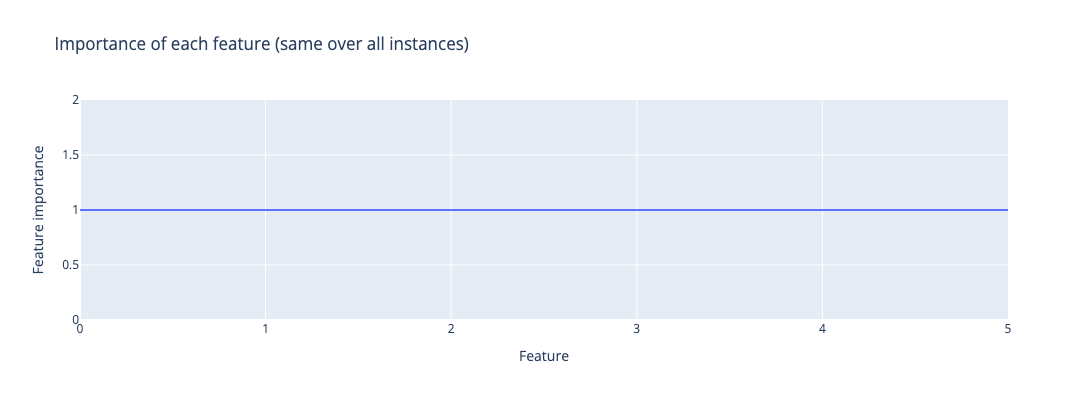

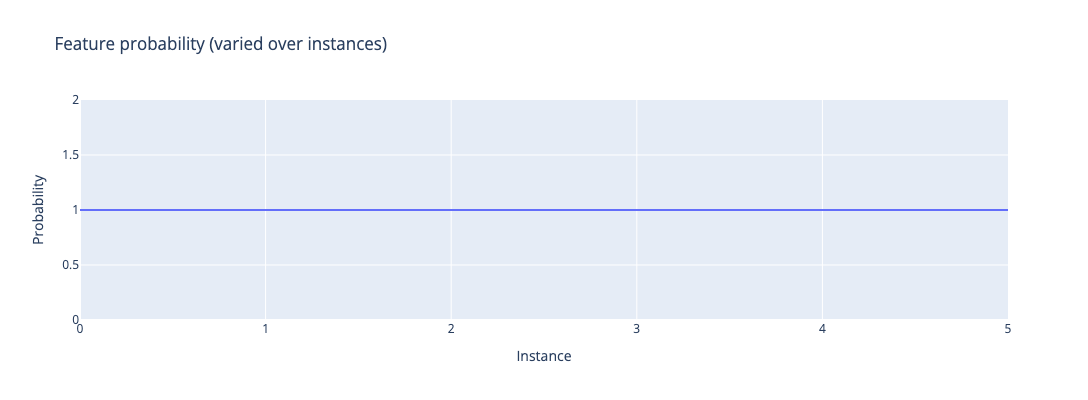

In [27]:
cfg = Config(
    n_instances = 6,
    n_features = 6,
    n_hidden = 2,
)

# importance varies within features for each instance
# importance = (0.9 ** t.arange(cfg.n_features))
importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (1 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [35]:
feature_probability.shape

torch.Size([6, 1])

In [28]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

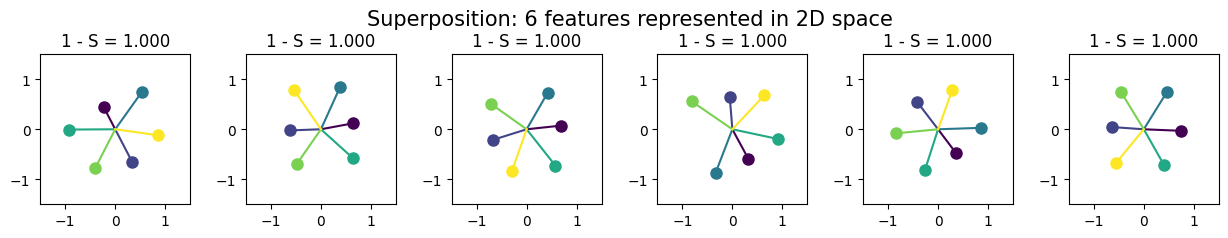

In [29]:
model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

### Different Importance

In [61]:
importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)

t.pow(2, importance - 1)

tensor([[0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [2.0000, 2.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [4.0000, 4.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [8.0000, 8.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

  0%|          | 0/10000 [00:00<?, ?it/s]

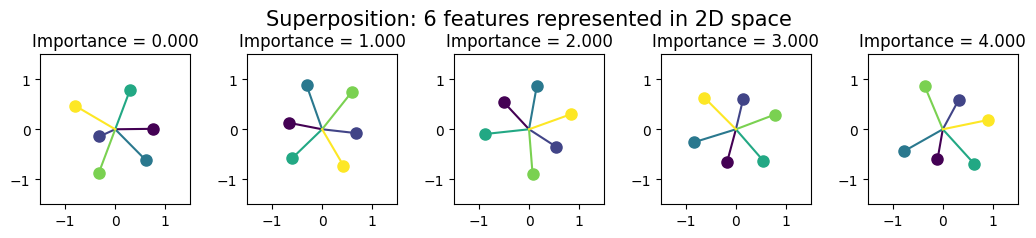

In [63]:
cfg = Config(
    n_instances = 5,
    n_features = 6,
    n_hidden = 2,
)

importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)
# importance = t.pow(2, importance - 1)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = None,
)

model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"Importance = {i:.3f}" for i in importance[:,0].squeeze()],
)

## More tree depth

### same importance

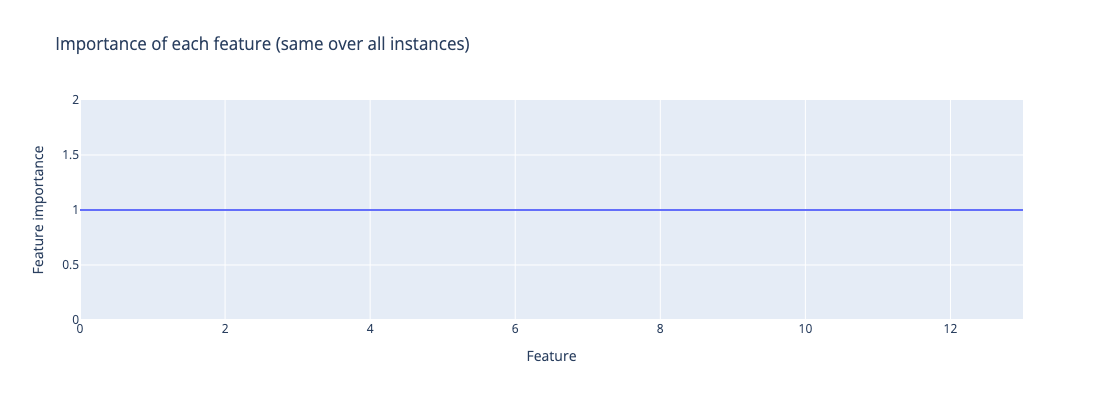

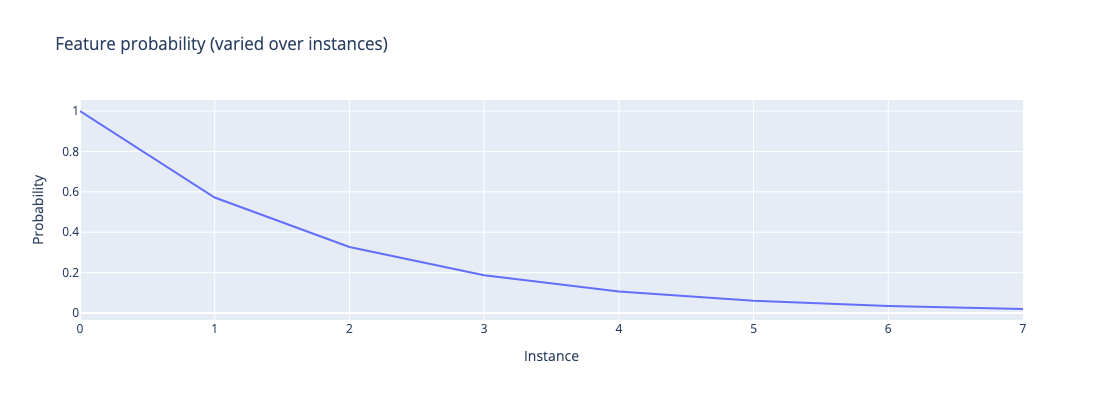

In [66]:
cfg = Config(
    n_instances = 8,
    n_features = 14,
    n_hidden = 2,
    branching_factor = 2,
    tree_depth = 3,
)


# importance varies within features for each instance
# importance = (0.9 ** t.arange(cfg.n_features))
importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")

# sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same over all instances)", labels={"y": "Feature importance", "x": "Feature"})
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (varied over instances)", labels={"y": "Probability", "x": "Instance"})

In [17]:
model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

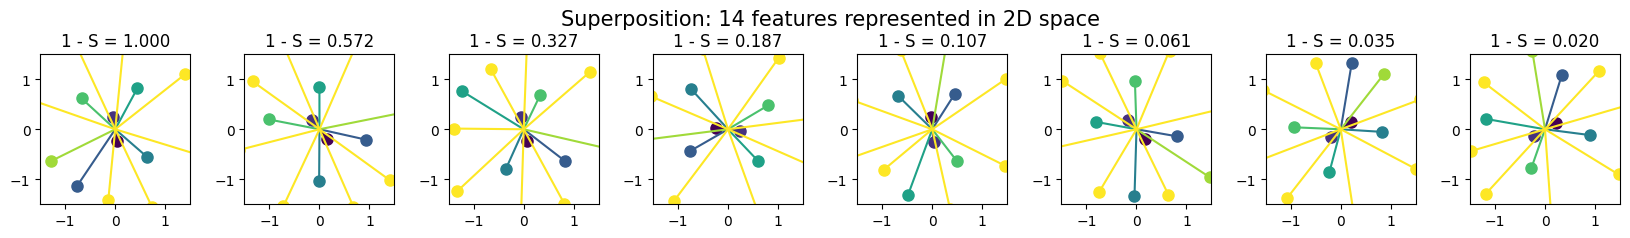

In [18]:
model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / (model.cfg.n_instances-1),
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

### different importance

In [68]:
importance.shape

torch.Size([1, 14])

  0%|          | 0/10000 [00:00<?, ?it/s]

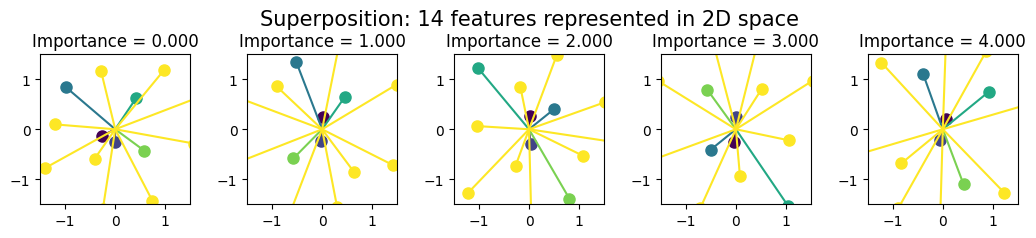

In [70]:
cfg = Config(
    n_instances = 5,
    n_features = 14,
    n_hidden = 2,
    branching_factor = 2,
    tree_depth = 3,
)

importance = t.ones((cfg.n_instances, cfg.n_features))
importance[:, 0] = t.arange(0, cfg.n_instances)
importance[:, 1] = t.arange(0, cfg.n_instances)
# importance = t.pow(2, importance - 1)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = None,
)

model.optimize(steps=10000)

plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles = [f"Importance = {i:.3f}" for i in importance[:,0].squeeze()],
)

In [ ]:
from transformer_lens import HookedTransformer, FactoredMatrix
from transformer_lens.hook_points import HookPoint

from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

First, here's some code to load in autoencoders. Neel trained 2 different autoencoders, denoted with the parameter `version` (they are 25 and 47 on HuggingFace). These have the same architectures & were trained in the same way, but with different random seeds. The reason we do this is as follows: one way of testing how "real" a feature is is to see whether it's highly correlated with a feature in a different run. If two different runs find the same feature, that's evidence that the feature is universal rather than just a fluke of the training process. From Logan Riggs' post: *there are many ways to be wrong & only one way to be right*.

We'll load in both of these autoencoders into the same `AutoEncoder` instance (as 2 different **instances**).

A few notes / pieces of terminology:

- Because we're working with an MLP layer, we'll use `d_mlp` to denote the size of the MLP layer - this is equivalent to `n_hidden` or `n_features` in the previous section. We'll keep using `n_hidden_ae` to refer to the autoencoder's hidden dimension.
- The **dictionary multiplier** (denoted `dict_mult` below) is the factor by which the autoencoder's hidden dimension is larger than the model's hidden dimension, in other words `n_hidden_ae = dict_mult * d_mlp`.
- As mentioned in the previous section, there's now possibility for confusion when we refer to "neurons" - so we'll disambiguate by using the term "autoencoder neurons" for the hidden values of our autoencoder, vs just "neurons" to refer to the hidden values of our MLP layer. We'll still refer to "neuron resampling" when we talk about resampling autoencoder neurons, though.
- On the flipside, there's less confusion when we refer to "features" - since we're working with an LLM rather than a toy data-generating process with features explicitly coded in, when we say "features" in this section we're usually referring to the autoencoder's hidden values rather than theoretical "true features" of the data-generation process.

In [ ]:
VERSION_DICT = {"run1": 25, "run2": 47}

def load_autoencoder_from_huggingface(versions: List[str] = ["run1", "run2"]):
    state_dict = {}

    for version in versions:
        version_id = VERSION_DICT[version]
        # Load the data from huggingface (both metadata and state dict)
        sae_data: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}_cfg.json")
        new_state_dict: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}.pt", force_is_torch=True)
        # Add new state dict to the existing one
        for k, v in new_state_dict.items():
            state_dict[k] = t.stack([state_dict[k], v]) if k in state_dict else v

    # Get data about the model dimensions, and use that to initialize our model (with 2 instances)
    d_mlp = sae_data["d_mlp"]
    dict_mult = sae_data["dict_mult"]
    n_hidden_ae = d_mlp * dict_mult

    cfg = AutoEncoderConfig(
        n_instances = 2,
        n_input_ae = d_mlp,
        n_hidden_ae = n_hidden_ae,
    )

    # Initialize our model, and load in state dict
    autoencoder = AutoEncoder(cfg)
    autoencoder.load_state_dict(state_dict)

    return autoencoder


autoencoder = load_autoencoder_from_huggingface()

25_cfg.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

25.pt:   0%|          | 0.00/269M [00:00<?, ?B/s]

47_cfg.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

47.pt:   0%|          | 0.00/269M [00:00<?, ?B/s]

We also load in our model from TransformerLens, and inspect it. The model we'll be working with is 1-layer, with `d_mlp = 2048`. Note that the autoencoder we defined above has a dictionary multiplier of 8, meaning it has 2048 * 8 = 16384 neurons!

In [ ]:
model = HookedTransformer.from_pretrained("gelu-1l").to(device)

print(model)

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/213M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()


Lastly, we load in a large batch of data which is representative of the data which the autoencoder was trained on:

In [ ]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]
print("Tokens shape: ", all_tokens.shape)

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

Tokens shape:  torch.Size([215402, 128])


### Exercise - find the sparsity

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-30 minutes on this exercise.
```

You should fill in the `get_feature_probability` function below, which returns the fraction of time each autoencoder feature fires (as a tensor of shape `(2, n_hidden_ae)` - the latter `2` dimension because we have 2 different instances, and you should return the feature probabilities for each feature in both instances).

Most of this should be familiar - in the previous sections you've already written code to calculate the model's hidden activations and measured feature sparsity (when you were writing your code to resample autoencoder neurons). The only new thing here is how the hidden activations are generated. You should:

- Run the transformer model on `tokens`, and get the post-GELU activations with shape `(batch_size, seq_len, d_mlp)`.
- Rearrange this into shape `(batch_size * seq_len, d_mlp)`, because the activations at each token are a separate input for our autoencoder.
- Duplicate this tensor into `(batch_size * seq_len, 2, d_mlp)`, because we have 2 different autoencoder instances.
- Run the autoencoder on these activations, finding the activations (and the fraction of times the feature is active, over the `batch_size * seq_len` dimension).

<details>
<summary>Help - I don't know / remember how to extract internal activations from a <code>HookedTransformer</code> model.</summary>

The easiest way is to use an `ActivationCache` object. We can run:

```python
logits, cache = model.run_with_cache(tokens, names_filter=['blocks.0.mlp.hook_post'])
```

where `names_filter` is a list of the names of the layers we want to extract activations from (in this case, the post-GELU activations in the first and only MLP layer). We can then get the actual activations by indexing into the `cache` object with the same key we used in the `names_filter` argument.

</details>

In [ ]:
@t.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, "instance n_hidden_ae"]:
    '''
    Returns the feature probabilities (i.e. fraction of time the feature is active) for each feature in the
    autoencoder, averaged over all `batch * seq` tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)

    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert post_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    acts = autoencoder.forward(post_reshaped)[3]
    assert acts.shape == (batch_size * seq_len, 2, autoencoder.cfg.n_hidden_ae)

    return acts.mean(0)

# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i:i+50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Visualise sparsities for each instance
for i, lf in enumerate(log_freq):
    hist(
        lf,
        title=f"Instance #{i+1}: Log Frequency of Features",
        labels={"x": "log<sub>10</sub>(freq)"},
        histnorm="percent",
        template="ggplot2"
    )

We can see that the features are clearly bimodal. Interestingly, further investigation of the lower-frequency group reveals that almost all these features are meaningless, with very high cosine similarity to each other:

In [ ]:
# Get all the rare features
is_rare = feature_probability[0] < 1e-4
rare_encoder_directions = autoencoder.W_enc[0, :, is_rare]
rare_encoder_directions_normalized = rare_encoder_directions / rare_encoder_directions.norm(dim=0, keepdim=True)

# Compute their pairwise cosine similarities & sample randomly from this N*N matrix of similarities
cos_sims_rare = (rare_encoder_directions_normalized.T @ rare_encoder_directions_normalized).flatten()
cos_sims_rare_random_sample = cos_sims_rare[t.randint(0, cos_sims_rare.shape[0], (10000,))]

# Plot results
hist(
    cos_sims_rare_random_sample,
    marginal="box",
    title="Cosine similarities of random rare encoder directions with each other",
    labels={"x": "Cosine sim"},
    histnorm="percent",
    template="ggplot2"
)

In Neel's [Public Comment](https://docs.google.com/document/u/0/d/187jfZSbhRjjQaazjYlThBsKp3Q0Pw3VdIHVST9H2dvw/mobilebasic), he discusses this ultra-low frequency cluster (which was also found by Anthropic, although it was around size 5-10% rather than 60%). He speculates that these might be just a curious artifact of training (the encoder directions formed between different runs seem to be the same, although the decoder directions for these features are all very different!).

If you're interested in training autoencoders, you can read his document for more details and helpful tips. We won't be discussing the training of autoencoders on real models in these exercises; we'll just be working with Neel's pretrained autoencoder.

### Exercise - find the reconstruction loss

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

You should fill in the `get_reconstruction_loss` function below, which returns the average reconstruction loss (i.e. $L_2$ loss) of each autoencoder instance on a batch of data, in the form of a list of 2 values.

This should be very similar to the previous exercise, except rather than getting the activations & returning their sparsity, you should return the average reconstruction loss.

In [ ]:
@t.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[float, float]:
    '''
    Returns the reconstruction loss of each autoencoder instance on the given batch of tokens (i.e.
    the L2 loss between the activations and the autoencoder's reconstructions, averaged over all tokens).
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)

    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert post_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    _, l2_loss, _, _, post_reconstructed = autoencoder.forward(post_reshaped)
    assert l2_loss.shape == (batch_size * seq_len, 2) # shape is [datapoints n_instances=2]
    assert post_reconstructed.shape == (batch_size * seq_len, 2, model.cfg.d_mlp) # shape is [datapoints n_instances=2 d_mlp]

    # Print out the avg L2 norm of activations
    print("Avg L2 norm of acts: ", einops.reduce(post_reshaped.pow(2), "batch inst d_mlp -> inst", "mean").tolist())
    # Print out the cosine similarity between original neuron activations & reconstructions (averaged over neurons)
    print("Avg cos sim of neuron reconstructions: ", t.cosine_similarity(post_reconstructed, post_reshaped, dim=0).mean(-1).tolist())

    return l2_loss.mean(0).tolist()


reconstruction_loss = get_reconstruction_loss(all_tokens[:10], model, autoencoder)
print(reconstruction_loss)

Avg L2 norm of acts:  [0.11062075197696686, 0.11062075197696686]
Avg cos sim of neuron reconstructions:  [0.8816350698471069, 0.8813362121582031]


[0.01632196269929409, 0.01644236221909523]

You should find that the reconstruction loss is around 0.016 (and about the same for encoder-B). You can compare this to the average squared $L_2$ norm of the activations to get an idea of how good this is - this value is around 0.11, so we're doing a pretty good job (albeit not perfect) of reconstructing the activations.

You can also measure the average cosine similarity between the activations and the reconstructions over neurons. In other words, for each neuron we can store the activations & reconstructed activations over all datapoints, treating these as vectors of length `batch_size * seq_len`, then calculate their cosine similarity, and average them over all neurons. (Note the important distinction here - when calculating cos sim, we're reducing over the batch dimension then averaging these values over the `d_mlp` direction, rather than the other way around.) You should find values of around 88%, showing that on average the autoencoder reconstructs the neuron values pretty faithfully.

### Exercise - find the substitution loss

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 15-35 minutes on this exercise.
```

*Note - if you're less familiar with `TransformerLens` syntax, you might want to skip this exercise. It's not crucial to understanding the rest of the notebook.*

You should fill in the `get_substitution_loss` function below, which returns the average cross-entropy loss per token under each of the following 4 conditions:

- the clean model (no interventions),
- activations are replaced with encoder A's reconstructions,
- activations are replaced with encoder B's reconstructions,
- activations are zero-ablated.

It returns this as a tuple of 4 elements.

You can re-use some of your code above, to get the autoencoder's reconstruction. The easiest way to do this is to define a **hook function** which replaces the post-GELU activations with the autoencoder's reconstruction.

<details>
<summary>Help - I don't know / remember how to use hook functions in <code>HookedTransformer</code> model.</summary>

The basic syntax you'll need is:

```python
def hook_function(activations: Float[Tensor, "batch seq d_mlp"], hook: HookPoint):
    # Intervene on activations: calculating a tensor of 'new_activations'
    ...
    return new_activations
```

You can then run with hooks (and return the loss per token) using:

```python
loss = model.run_with_hooks(
    tokens,
    return_type = "loss",
    loss_per_token = True,
    fwd_hooks = [("blocks.0.mlp.hook_post", hook_function)],
)
```

</details>

Note - it is possible to do all of this in a single forward pass. However, it's probably easiest to break it up into 4 forward passes: one cached run which gives you the clean loss & the post-GELU activations, then three runs where you patch in with encoder A's reconstructions / encoder B's reconstructions / zero respectively. The solutions colab contains examples of both.

In [ ]:
# Solution which does everything in a single forward pass (more efficient but less interpretable):

@t.no_grad()
def get_substitution_loss(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[float, float, float, float]:
    '''
    Returns the substitution loss of the autoencoder on the given batch of tokens: in other words, the
    model's cross entropy loss subject to replacing the transformer's neuron activations with the
    autoencoder's reconstructed activations, or zero-ablating them.

    For efficiency, we do this all in one forward pass, but with 3 copies of the tokens (one for a
    clean run, and 2 for each of the autoencoder patching runs).
    '''
    batch_size, seq_len = tokens.shape
    copied_tokens = t.concat([tokens, tokens, tokens, tokens], dim=0)

    def hook_function(activations: Float[Tensor, "triple_batch seq d_mlp"], hook: HookPoint):

        # Reshape the activations along the `instances` dimension, so they can be passed into our autoencoder
        # (note, the activations are currently 3 copies of the same activations stacked along the batch dimension)
        autoencoder_input = einops.rearrange(
            activations[:2*batch_size],
            "(instance batch) seq d_mlp -> (batch seq) instance d_mlp",
            instance = 2
        )
        # Run our autoencoder, and return the reconstructed activations
        post_reconstructed = autoencoder.forward(autoencoder_input)[-1] # shape [batch*seq instance d_mlp]

        # Set the 2nd and 3rd batches in the `activations` tensor to these reconstructed activations
        activations[batch_size:-batch_size] = einops.rearrange(
            post_reconstructed,
            "(batch seq) instance d_mlp -> (instance batch) seq d_mlp",
            batch = batch_size,
        )
        # Zero-ablate the 4th batch
        activations[-batch_size:] = 0.0

        return activations

    loss: Tensor = model.run_with_hooks(
        copied_tokens,
        return_type = "loss",
        loss_per_token = True,
        fwd_hooks = [("blocks.0.mlp.hook_post", hook_function)],
    )
    loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation = [v.mean() for v in loss.chunk(4)]

    return loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation

In [ ]:
# Solution which breaks things up into 4 forward passes (more straightforward):

@t.no_grad()
def get_substitution_loss(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[float, float, float, float]:
    '''
    Returns the substitution loss of the autoencoder on the given batch of tokens: in other words, the
    model's cross entropy loss subject to replacing the transformer's neuron activations with the
    autoencoder's reconstructed activations, or zero-ablating them.

    We do this in 4 different forward passes: one `run_with_cache` to get the activation, and then 3
    separate patched forward passes.
    '''
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run (and get the clean loss)
    loss_clean, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"], return_type="loss")
    post = cache["blocks.0.mlp.hook_post"]
    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)

    # Use these to get 'post_reconstructed' (for both autoencoder A and B). We need to reshape back to (batch, seq) first
    post_reconstructed = autoencoder.forward(post_reshaped)[-1]
    post_reconstructed_A, post_reconstructed_B = einops.rearrange(
        post_reconstructed,
        "(batch seq) instance d_mlp -> instance batch seq d_mlp",
        batch = batch_size
    )

    # Define hook fn to replace activations with different values
    def hook_function(activations: Float[Tensor, "triple_batch seq d_mlp"], hook: HookPoint, new_activations):
        activations[:] = new_activations
        return activations

    # Run the hook function in 3 different cases: autoencoder A's reconstructions, B's reconstructions, and zero-ablation
    loss_reconstructed_A = model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[("blocks.0.mlp.hook_post", partial(hook_function, new_activations=post_reconstructed_A))],
    )
    loss_reconstructed_B = model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[("blocks.0.mlp.hook_post", partial(hook_function, new_activations=post_reconstructed_B))],
    )
    loss_zero_ablation = model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[("blocks.0.mlp.hook_post", partial(hook_function, new_activations=0.0))],
    )

    return loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation

Once you've done this, run the code below to find the **score** of an autoencoder. This is defined as 1 minus the fraction of increase in loss their reconstructions cause relative to zero-ablation. The idea here is that a score of zero means the autoencoder's reconstructions are no better than zero-ablation, and a score of 1 means their reconstructions are perfect, not increasing loss at all when we substitute them in. You should find your instances' reconstruction scores are at least 90%.

In [ ]:
loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation = get_substitution_loss(all_tokens[:5], model, autoencoder)

score_A = ((loss_zero_ablation - loss_reconstructed_A)/(loss_zero_ablation - loss_clean))
score_B = ((loss_zero_ablation - loss_reconstructed_B)/(loss_zero_ablation - loss_clean))

print(f"Reconstruction Score A: {score_A:.2%}")
print(f"Reconstruction Score B: {score_B:.2%}")

Reconstruction Score A: 92.13%
Reconstruction Score B: 91.81%


Now we've looked at some high-level stuff, let's get down to some deeper dives: trying to interpret particular neurons.


### Exercise - find highest-activating tokens

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 20-35 minutes on this exercise.
```


The first thing we should do is find the highest-activating sequences for each feature. This can give us a good starting idea of what this neuron is doing. Note that this shouldn't be the end point of our analysis, because this kind of methodology can suffer from the **interpretability illusion** - the top activating examples from a particular dataset often look like they tell a convincing story, until you try a different dataset and get a totally different story! Ideally you'd want to perform tests like passing particular sequences through the model which you expect will / won't cause your feature to activate, thereby testing your hypotheses. However, this still a useful starting point.

The function `highest_activating_tokens` returns a tensor of shape `(k, 2)`, where the `i`-th element of this tensor are the (batch, seq) indices of the `i`-th highest-activating token (i.e. the token on which the `feature_idx`-th neuron in the autoencoder has the largest activations). If also returns a tensor of shape `(k,)` containing these activation values.

Note that the function also takes a boolean argument `autoencoder_B`, which is `True` when we're looking at the second autoencoder (i.e. the second instance).

Tip - you can make this function a lot more efficient by calculating the activations explicitly, rather than by extracting `acts` from the 5-tuple returned by `autoencoder.forward`. This is because you only need one feature - it's wasteful to calculate all 16384! You can just copy & modify code from the start of the `forward` method, so it only applies to a single feature.

You can test your function by running the code in the cell below. Click the toggle below to see what sequences you should be getting.


<details>
<summary>Spoiler: sequences you should be getting</summary>

If you run the function with at least a batch size of ~100, you should observe the following pattern: **the top-activating tokens for feature #7 are consistently pronouns like ` I`, ` you` or ` it`, commonly following either the word ` and` or ` but`.

</details>

In [ ]:
@t.inference_mode()
def highest_activating_tokens(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    feature_idx: int,
    autoencoder_B: bool = False,
    k: int = 10,
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = tokens.shape
    instance_idx = 1 if autoencoder_B else 0

    # Get the post activations from the clean run
    cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])[1]
    post = cache["blocks.0.mlp.hook_post"]
    post_reshaped = einops.rearrange(post, "batch seq d_mlp -> (batch seq) d_mlp")

    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code is copied from the first part of the 'forward' method of the AutoEncoder class
    h_cent = post_reshaped - autoencoder.b_dec[instance_idx]
    acts = einops.einsum(
        h_cent, autoencoder.W_enc[instance_idx, :, feature_idx],
        "batch_size n_input_ae, n_input_ae -> batch_size"
    )

    # Get the top k largest activations
    top_acts_values, top_acts_indices = acts.topk(k)

    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return t.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values


def display_top_sequences(top_acts_indices, top_acts_values, tokens):
    table = Table("Sequence", "Activation", title="Tokens which most activate this feature")
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq = ""
        for i in range(max(seq_idx-5, 0), min(seq_idx+5, all_tokens.shape[1])):
            new_str_token = model.to_single_str_token(tokens[batch_idx, i].item()).replace("\n", "\\n")
            # Highlight the token with the high activation
            if i == seq_idx: new_str_token = f"[b u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        table.add_row(seq, f'{value:.2f}')
    rprint(table)

tokens = all_tokens[:200]
top_acts_indices, top_acts_values = highest_activating_tokens(tokens, model, autoencoder, feature_idx=7, autoencoder_B=False)
display_top_sequences(top_acts_indices, top_acts_values, tokens)

                 Tokens with the highest activations                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Sequence                                              ┃ Activation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│  to me as well and I have yet to have                 │ 2.55       │
│  Don Jaime I and you will arrive in Plaza             │ 2.14       │
│ <|BOS|>in is True and it is the same user             │ 1.74       │
│ <|BOS|> image file, and it should have the\n          │ 1.55       │
│  meets the new one and it’s the hub                   │ 1.48       │
│  of her situation, but I did refer her to             │ 1.23       │
│  life, growing up, she was involved in her            │ 1.05       │
│  through grace — and now he shares that story through │ 0.97       │
│  only supports False, but it should not be a          │ 0.93       │
│  me as well and I have yet to have a                  │ 0.88       │
└───────────────────────────────────────────────────────┴────────────┘

### Exercise - find a feature's logit effect

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

Understanding when it fires is one thing, but it's also interesting to see what tokens this feature boosts / suppresses when it fires.

Try to find the 10 most boosted / suppressed tokens for the `feature_idx = 7` which is shown above. In other words, when you multiply the decoder weight with the GELU-1l model's MLP output matrix and unembedding matrix, which tokens are most affected?



<details>
<summary>Hint - names of the weights</summary>

You will need the following two weight matrices:

```python
model.W_out[0] # shape [d_mlp, d_model]
model.W_U # shape [d_model, d_vocab]
```

</details>

<details>
<summary>Solution (some sample code & what you should find when you run it)</summary>

Code to get & print the results:

```python
W_dec_vector = autoencoder.W_dec[0, 7]

W_dec_logits = W_dec_vector @ model.W_out[0] @ model.W_U

top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)
```

You should find that the most boosted token is `'ll` - not surprising given this commonly follows `I`, `we` and `it`. It seems likely that this feature is mostly a **bigram feature**. Some other highly boosted tokens also commonly follow these pronouns, e.g. `hope`, `wouldn`, `definitely`.

Note - when we say **bigram feature**, we mean features which seem to exist in order to model bigram frequences: *"this token is X, so next token is more/less likely to be Y"*. These are uninteresting because they don't require attention heads to move information around, they're just the feature responding to something already in the residual stream & writing directly to the output.

However, this feature might not only be modelling bigrams. We saw that it activates most when the pronoun is followed by tokens like `and` or `but`. Possibly this is better described as a **trigram feature**, which is slightly more interesting because it must involve attention heads in some way. Can you find any **[skip-trigram](https://transformer-circuits.pub/2021/framework/index.html#interpretation-as-skip-trigrams) features**?

The bottom 10 tokens don't seem very interpretable - this is pretty common (most of the time model components are better thought of as boosting rather than suppressing components - although [not all the time](https://arxiv.org/abs/2310.04625)!)

</details>

In [ ]:
W_dec_vector = autoencoder.W_dec[0, 7]

W_dec_logits = W_dec_vector @ model.W_out[0] @ model.W_U

top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)

Top tokens:
(1.88) 'll
(1.56) eding
(1.52)  certainly
(1.52)  hope
(1.51) OULD
(1.48)  wouldn
(1.44) cheon
(1.40)  definitely
(1.39)  seem
(1.36)  sincerely

Bottom tokens:
(-1.32)  Number
(-1.17)  Forty
(-1.11) ignon
(-1.10)  Poly
(-1.10)  Discussion
(-1.10)  Memory
(-1.06) witz
(-1.05)  Standard
(-1.05) ograf
(-1.01)  Cart

### Exercise - examine this feature in the neuron basis

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

An important question which we've not asked yet - **are the features sparse or dense in the neuron basis?** When we say a feature sparse in the neuron basis, we mean that this feature only has exposure to a small number of neurons. In the extreme case, if a feature is literally identical to a neuron, then the corresponding feature vector `W_dec[instance, feature_idx, :]` contains all 0s, except for 1 at a single neuron. On the other hand, if a feature is dense in the neuron basis, this is evidence that our autoencoder is finding features which are genuinely in superposition (or at least polysemantic), and these features wouldn't be found if we just looked at individual neurons in the MLP layer.

(Note, we're looking at the decoder weights here, because as we've discussed before, the encoder weights might be pushed apart from each other by the necessity of them having to reduce interference between features, and this might make them artificially dense in the neuron basis if this pushes them away from the direction of any single neuron.)

Look at the top neurons which the previously analyzed `instance=0, feature_idx=7` feature is most exposed to. What fraction of this feature's $L_1$ norm is taken up by the top neuron? By the top 3 neurons? Do these neurons activate most strongly on similar tokens to this feature (i.e. pronouns)? Do they boost tokens similar to the ones boosted by this feature (e.g. `'ll` and other tokens that commonly follow pronouns)?


In [ ]:
l1_norms = autoencoder.W_dec[0, 7, :].abs()
l1_norms_as_fraction = l1_norms / l1_norms.sum()

top_l1_norms_values, top_l1_norms_indices = l1_norms_as_fraction.topk(10)

top_l1_neurons_top_activating_tok_indices = (model.W_E @ model.W_in[0])[:, top_l1_norms_indices].topk(k=3, dim=0).indices
top_l1_neurons_top_activating_toks = [model.to_str_tokens(indices) for indices in top_l1_neurons_top_activating_tok_indices.T]

top_l1_neurons_top_predicted_tok_indices = (model.W_U.T @ model.W_out[0].T)[:, top_l1_norms_indices].topk(k=3, dim=0).indices
top_l1_neurons_top_predicted_toks = [model.to_str_tokens(indices) for indices in top_l1_neurons_top_predicted_tok_indices.T]

table = Table(
    "Neuron alignment\n(% of L1)", "Top activating tokens", "Top boosted tokens",
    title = "Top neurons by L1 norm of decoder, along with those neurons' top activating & predicted tokens"
)
for i in range(10):
    table.add_row(
        f"{top_l1_norms_values[i]:.2%}",
        ", ".join([repr(x) for x in top_l1_neurons_top_activating_toks[i]]),
        ", ".join([repr(x) for x in top_l1_neurons_top_predicted_toks[i]])
    )
rprint(table)

Top neurons by L1 norm of decoder, along with those neurons' top activating & predicted tokens 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neuron alignment ┃                               ┃                                          ┃
┃ (% of L1)        ┃ Top activating tokens         ┃ Top boosted tokens                       ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.71%            │ ' he', ' she', ' Has'         │ ' spared', ' commanded', ' accomplished' │
│ 0.57%            │ 'Cre', '�', ' Cur'            │ 'ERN', 'logging', ' fate'                │
│ 0.53%            │ ' hipp', 'Za', 'fficacy'      │ ' not', ' -----', 'öt'                   │
│ 0.52%            │ ' don', ' THEY', ' whose'     │ 's', 'visors', 'ighs'                    │
│ 0.52%            │ ',’', '!’', '?’'              │ ' Wrote', "';", ' JOHN'                  │
│ 0.48%            │ '\r\n', ' And', ' Ep'         │ ':', '):', ']):'                         │
│ 0.47%            │ ' demonstr', ' mour', 'onstr' │ 'argv', 'objects', 'context'             │
│ 0.47%            │ ' GENER', ' observ', ' Oper'  │ 'binant', 'edly', 'idone'                │
│ 0.46%            │ ' fait', ' and', ' obsc'      │ '0', ' ·', '5'                           │
│ 0.46%            │ 'she', 'She', ' Fra'          │ 'woke', 'sembles', ' respects'           │
└──────────────────┴───────────────────────────────┴──────────────────────────────────────────┘


<details>
<summary>Spoiler - what you should find</summary>

You should find that this feature is very dense in the neuron basis, with less than 1% of its $L_1$ norm being associated with any single neuron.

You should also find that a handful of the neurons (but far from all of them) activate on similar tokens to this feature. For example, the top neuron (still with only 0.71% $L_1$ exposure from this feature) has top-activating tokens `[' he', ' she']`, the 4th neuron has `' THEY'` as its second-highest activating token, and the 10th neuron has `['she', 'She']` as its top two. The story is roughly similar when we look at which tokens are most strongly predicted for this feature, with the top neuron & 10th neuron both boosting verbs which commonly follow pronouns (although interestingly, none of the top 10 neurons seem to have `'ll` as one of their top boosted tokens - another sign that this feature has spotted something which isn't just a property of the neuron basis).

The full output produced from the solution code (ignoring color formatting!) is:

```
Top neurons by L1 norm of decoder, along with those neurons' top activating & predicted tokens

Neuron alignment (pct of L1) = 0.71%
top activating tokens = [' he', ' she', ' Has']
top boosted tokens = [' spared', ' commanded', ' accomplished']

Neuron alignment (pct of L1) = 0.57%
top activating tokens = ['Cre', '�', ' Cur']
top boosted tokens = ['ERN', 'logging', ' fate']

Neuron alignment (pct of L1) = 0.53%
top activating tokens = [' hipp', 'Za', 'fficacy']
top boosted tokens = [' not', ' -----', 'öt']

Neuron alignment (pct of L1) = 0.52%
top activating tokens = [' don', ' THEY', ' whose']
top boosted tokens = ['s', 'visors', 'ighs']

Neuron alignment (pct of L1) = 0.52%
top activating tokens = [',’', '!’', '?’']
top boosted tokens = [' Wrote', "';", ' JOHN']

Neuron alignment (pct of L1) = 0.48%
top activating tokens = ['\r\n', ' And', ' Ep']
top boosted tokens = [':', '):', ']):']

Neuron alignment (pct of L1) = 0.47%
top activating tokens = [' demonstr', ' mour', 'onstr']
top boosted tokens = ['argv', 'objects', 'context']

Neuron alignment (pct of L1) = 0.47%
top activating tokens = [' GENER', ' observ', ' Oper']
top boosted tokens = ['binant', 'edly', 'idone']

Neuron alignment (pct of L1) = 0.46%
top activating tokens = [' fait', ' and', ' obsc']
top boosted tokens = ['0', ' ·', '5']

Neuron alignment (pct of L1) = 0.46%
top activating tokens = ['she', 'She', ' Fra']
top boosted tokens = ['woke', 'sembles', ' respects']
```

</details>

### Exercise - find some fun features! (optional)

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 45 minutes on this exercise.
```

There are many more fun features to find in this model. In the first 1000 features for instance A, you should find:

- A feature which fires on Django syntax (the Python library), and predicts the string `django` following an open bracket (this is importantly different from just a regular bigram feature, because it requires the context before the left braacket to detect that the library is Django).
- A feature which fires on dashes following the word `multi`, and predicts words which commonly follow (e.g. `multi-million` or `multi-purpose`).
- A feature which fires on the digit `0` when it's part of a year (particularly when it's the hundreds digit) e.g. in `2012`, and boosts `0` and `1`.

<br>

Can you find these features, e.g. by passing in prompts and seeing which features activate most?

<br>

Can you find other metrics which lead you to interpretable prompts? We mentioned earlier that bigram features are less interesting than features which require the existence of attention heads to move information around. What happens when you zero-ablate the attention heads at all probabilities except for those where a token is attending to itself, and look for features which are most affected by this ablation? Are any of these features interesting?

## Suggested paper replications

<br>

### [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html#phase-change)

There are several aspects of this paper which we didn't cover in these exercises. In particular, **superposition as a phase change** studies the interaction between sparsity and relative feature importance, and finds a phase change in the optimal weight configuration as these inputs are varied. Some examples can be found in [this notebook](https://github.com/wattenberg/superposition/blob/main/Exploring_Exact_Toy_Models.ipynb)

This might be a good replication for you if:

* You enjoy diving into the specific mathematical details of superposition
* You find theoretical work interesting, as well as empirical work
* You've enjoyed the first ~3 exercise sets in this section

<br>

### [Polysemanticity and Capacity in Neural Networks](https://arxiv.org/pdf/2210.01892.pdf)

This is a paper by Redwood Research, which builds on the ideas we discussed in the first three four of this paper (toy models of superposition, and the results on feature geometry).

They deeply study a measure called capacity, which is the same as what we called dimensionality above. Their results suggest an explanation for why features are often sharply "pinned" to either 0 or 1 capacity (i.e. not represented at all, or represented orthogonally to all other features).

This might be a good replication for you if:

* You enjoy diving into the specific mathematical details of superposition
* You're comfortable with mathematical topics like linear algebra and calculus
* You find theoretical work interesting, as well as empirical work
* You've enjoyed the first ~4 exercise sets in this section

<br>

<!-- ### [Finding Neurons in a Haystack: Case Studies with Sparse Probing](https://arxiv.org/abs/2305.01610)

The authors train a set of sparse linear probes on neuron activations to predict the presence of certain input features. They manage to find **sparse combinations of neurons which represent many features in superposition**, e.g. a neuron which activates on the bigram phrase "social security" but not either word individually (see image below).

Note that this paper is slightly less relevant now that dictionary learning with SAEs has superceded its methodology - but it still represents a large step forward for the goal of extracting features from superposition in MLPs.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/socialsecurity.png" width="750"> -->


## Suggested topics for further exploration

<br>

### [Softmax Linear Units](https://transformer-circuits.pub/2022/solu/index.html)

This is a proposed architectural change which appears to increase the number of interpretable MLPs with low performance cost. In particular, it may reduce the instance of superposition.

TL;DR: SOLU is an activation function $\vec{x} \to \vec{x} * \operatorname{softmax}(\vec{x})$ which encourages sparsity in activations in the same way that softmax encourages sparsity (often softmax'ed probability distributions have one probability close to one and the others close to zero). Encouraging activation sparsity might make it harder for neurons to be polysemantic.

Replication of the results of this paper might not be a practical final week project. However, several transformers in the TransformerLens library have been trained with SOLU (see the [model page](https://neelnanda-io.github.io/TransformerLens/generated/model_properties_table.html) for more details), which makes them a good candidate for closer study. Some questions you might want to explore:

- How do Neel's SoLU and GELU models compare in [neuroscope](https://neuroscope.io/) under the polysemanticity metric used in the SoLU paper? (what fraction of neurons seem monosemantic when looking at the top 10 activating dataset examples for 1 minute)
- The SoLU metrics for polysemanticity are somewhat limited, since they only provide information about whether a neuron is monosemantic when activating strongly (and this may not be corrrelated to whether it is monosemantic in general - see [this caveat](https://transformer-circuits.pub/2022/solu/index.html#:~:text=be%20reverse%2Dengineered.-,CAVEAT,-Since%20publication%2C%20we%27ve) in the paper). Can you find any better metrics? Can you be more reliable, or more scalable?
- The paper [speculates](https://transformer-circuits.pub/2022/solu/index.html#section-4-3) that the LayerNorm after the SoLU activations lets the model "smuggle through" superposition, by smearing features across many dimensions, having the output be very small, and letting the LayerNorm scale it up. Can you find any evidence of this in solu-1l?

<br>

### [Towards Monosemanticity: Decomposing Language Models With Dictionary Learning](https://transformer-circuits.pub/2023/monosemantic-features/index.html)

There are many other interesting topics from Anthropic's dictionary learning paper which we didn't have time to dive into here, such as automated interpretability, feature motifs, and finite-state automata.

There's also a [Future Work](https://transformer-circuits.pub/2023/monosemantic-features/index.html#discussion-future-work) section at the end, which readers might find interesting for any project ideas!

<br>

### [Exciting Open Problems In Mech Interp v2](https://docs.google.com/document/d/1lIIzMjenXh-U0j5jkuqSDTawCoMNW4TqUlxk7mmbmRg/edit)

This document was written by Neel, and it collates a bunch of interesting open problems in mech interp (with a strong focus on SAE-related ones). Again, many of these could make great capstone projects! We encourage you to pick more achievable, less ambitious projects from this list though.

If any of the projects you're interested in involve training a sparse autoencoder, we *strongly* recommend [this post](https://www.lesswrong.com/posts/fifPCos6ddsmJYahD/my-best-guess-at-the-important-tricks-for-training-1l-saes) by Arthur Conmy, which collates a bunch of different techniques for training SAEs well (most of which we didn't cover in these exercises).